In [1]:
%load_ext autoreload
%autoreload 2

import numpy as np
from scipy.sparse import csc_array

import matplotlib.pyplot as plt
import matplotlib as mpl

# default parameters of the plot layout
plt.rcParams["text.usetex"] = True  # use latex
plt.rcParams["font.size"] = 13
plt.rcParams["figure.dpi"] = 300
plt.rcParams["figure.constrained_layout.use"] = True

from qs_mps.applications.Z2.exact_hamiltonian import *
from qs_mps.sparse_hamiltonians_and_operators import diagonalization, sparse_magnetization, sparse_pauli_x, sparse_pauli_z
from qs_mps.mps_class import MPS

# Periodic Boundary Condition Time Evolution

We are going to check the validity of the MPO for time evolution with the pbc hamiltonian. Hence, we are going to perform exact diagonalization with sparse matrices and compare the results.

## 1. Exact Time Evolution

We are going to perform two types of evolution:
- a. Start with the vacuum in the roughening, apply a string operator, evolve with the same hamiltonian
- b. Start with the string in the confined, evolve with the hamiltonian in the roughening region

### 1.a.1 Dual Hamiltonian in the vacuum roughening region

In [2]:
def dual_ham(l,L,g, cx: list=[], cy: list=[]):
    # degrees of freedom
    dof = l*L + 1

    # charges
    charges = np.ones((l,L+1))
    if len(cx) != 0:
        charges[cy[0],cx[0]] = -1
        charges[cy[1],cx[1]] = -1
    prod_charges = [1] + np.prod(charges[1:], axis=1).tolist()
    
    # initialize
    O = csc_array((2**dof, 2**dof), dtype=complex)
    H_sigmas = O
    H_taus = O
    H_plaquettes = O

    # first column of sigma are local
    for i in range(l):
        H_sigmas += sparse_pauli_z(n=i*L, L=dof)
    
    # horizontal zz interactions, we exclude the last column of sigmas
    for j in range(l):
        for i in range(L-1):
            H_sigmas += sparse_pauli_z(n=i+j*L, L=dof) @ sparse_pauli_z(n=(i+1)+j*L, L=dof)

    # horizontal zz interactions, last column of sigmas
    for j in range(l):
        H_sigmas += np.prod(prod_charges[:(j+1)]) * sparse_pauli_z(n=j*L+L-1, L=dof) @ sparse_pauli_z(n=l*L, L=dof)

    # vertical zz interactions 
    for j in range(L):
        for i in range(l):
            H_taus += np.prod(charges[(i+1)%l,:(j+1)]) * sparse_pauli_z(n=i*L+j, L=dof) @ sparse_pauli_z(n=((i+1)%l)*L+j, L=dof)

    # plaquette terms
    for i in range(l*L):
        H_plaquettes += sparse_pauli_x(n=i, L=dof)

    return - g * H_sigmas - g * H_taus - 1/g * H_plaquettes

In [3]:
l = 2
L = 3
g = 0.75
H_vr = dual_ham(l,L,g)
e, psi0 = diagonalization(H_vr, sparse=True)
print(len(e),psi0.shape, e)

1 (128, 1) [-12.3119519]


In [4]:
# charges
charges = np.ones((l,L+1))
# if len(cx) != 0:
#     charges[cy[0],cx[0]] = -1
#     charges[cy[1],cx[1]] = -1
prod_charges = [1] + np.prod(charges[1:], axis=1).tolist()
print(charges)
print(charges[1:])
print(prod_charges)

[[1. 1. 1. 1.]
 [1. 1. 1. 1.]]
[[1. 1. 1. 1.]]
[1, 1.0]


### 1.a.2 Application of the string operator

In [ ]:
def string_operator(cx: list=None, cy: list=None):
    
    
    pass

### 1.a.3 Evolution with the Dual Hamiltonian in the vacuum roughening region

### 1.b.1 Dual Hamiltonian in the string confined region

In [57]:
l = 2
L = 3
g = 10
cx = [1,2]
cy = [0,0]
H_sc = dual_ham(l,L,g,cx,cy)
e, psi0 = diagonalization(H_sc, sparse=True)
print(len(e),psi0.shape, e)
psi0 = psi0.reshape(2**(l*L+1))

1 (128, 1) [-120.001]


### 1.b.2 Evolution with Dual Hamiltonian in the string roughening region

In [62]:
l = 2
L = 3
g_r = 0.75
cx = [1,2]
cy = [0,0]
steps = 100
delta = 0.01
from scipy.sparse.linalg import expm

H_sr = dual_ham(l,L,g_r,cx,cy)

# observable, e.g. fidelity
fid = []
for N in range(steps):
    t = N*delta
    print(f"exact evolution at time: {t}")
    U_sr = expm(-1j*t*H_sr)
    psi_ev = U_sr @ psi0
    overlap = (psi_ev.T.conjugate() @ psi0).real
    fid.append(overlap)
    print(f"fidelity: {overlap}")

exact evolution at time: 0.0
fidelity: 0.9999999999999996
exact evolution at time: 0.01
fidelity: 0.9954030462367196
exact evolution at time: 0.02
fidelity: 0.9816644320694119
exact evolution at time: 0.03
fidelity: 0.9589402664760536
exact evolution at time: 0.04
fidelity: 0.9274886309925301
exact evolution at time: 0.05
fidelity: 0.8876664570215991
exact evolution at time: 0.06
fidelity: 0.8399252086095395
exact evolution at time: 0.07
fidelity: 0.7848054244075474
exact evolution at time: 0.08
fidelity: 0.7229301867136694
exact evolution at time: 0.09
fidelity: 0.6549975988128238
exact evolution at time: 0.1
fidelity: 0.5817723641301418
exact evolution at time: 0.11
fidelity: 0.5040765718310432
exact evolution at time: 0.12
fidelity: 0.4227798033006402
exact evolution at time: 0.13
fidelity: 0.33878868229171727
exact evolution at time: 0.14
fidelity: 0.253035998340252
exact evolution at time: 0.15
fidelity: 0.16646953822459631
exact evolution at time: 0.16
fidelity: 0.080040763724980

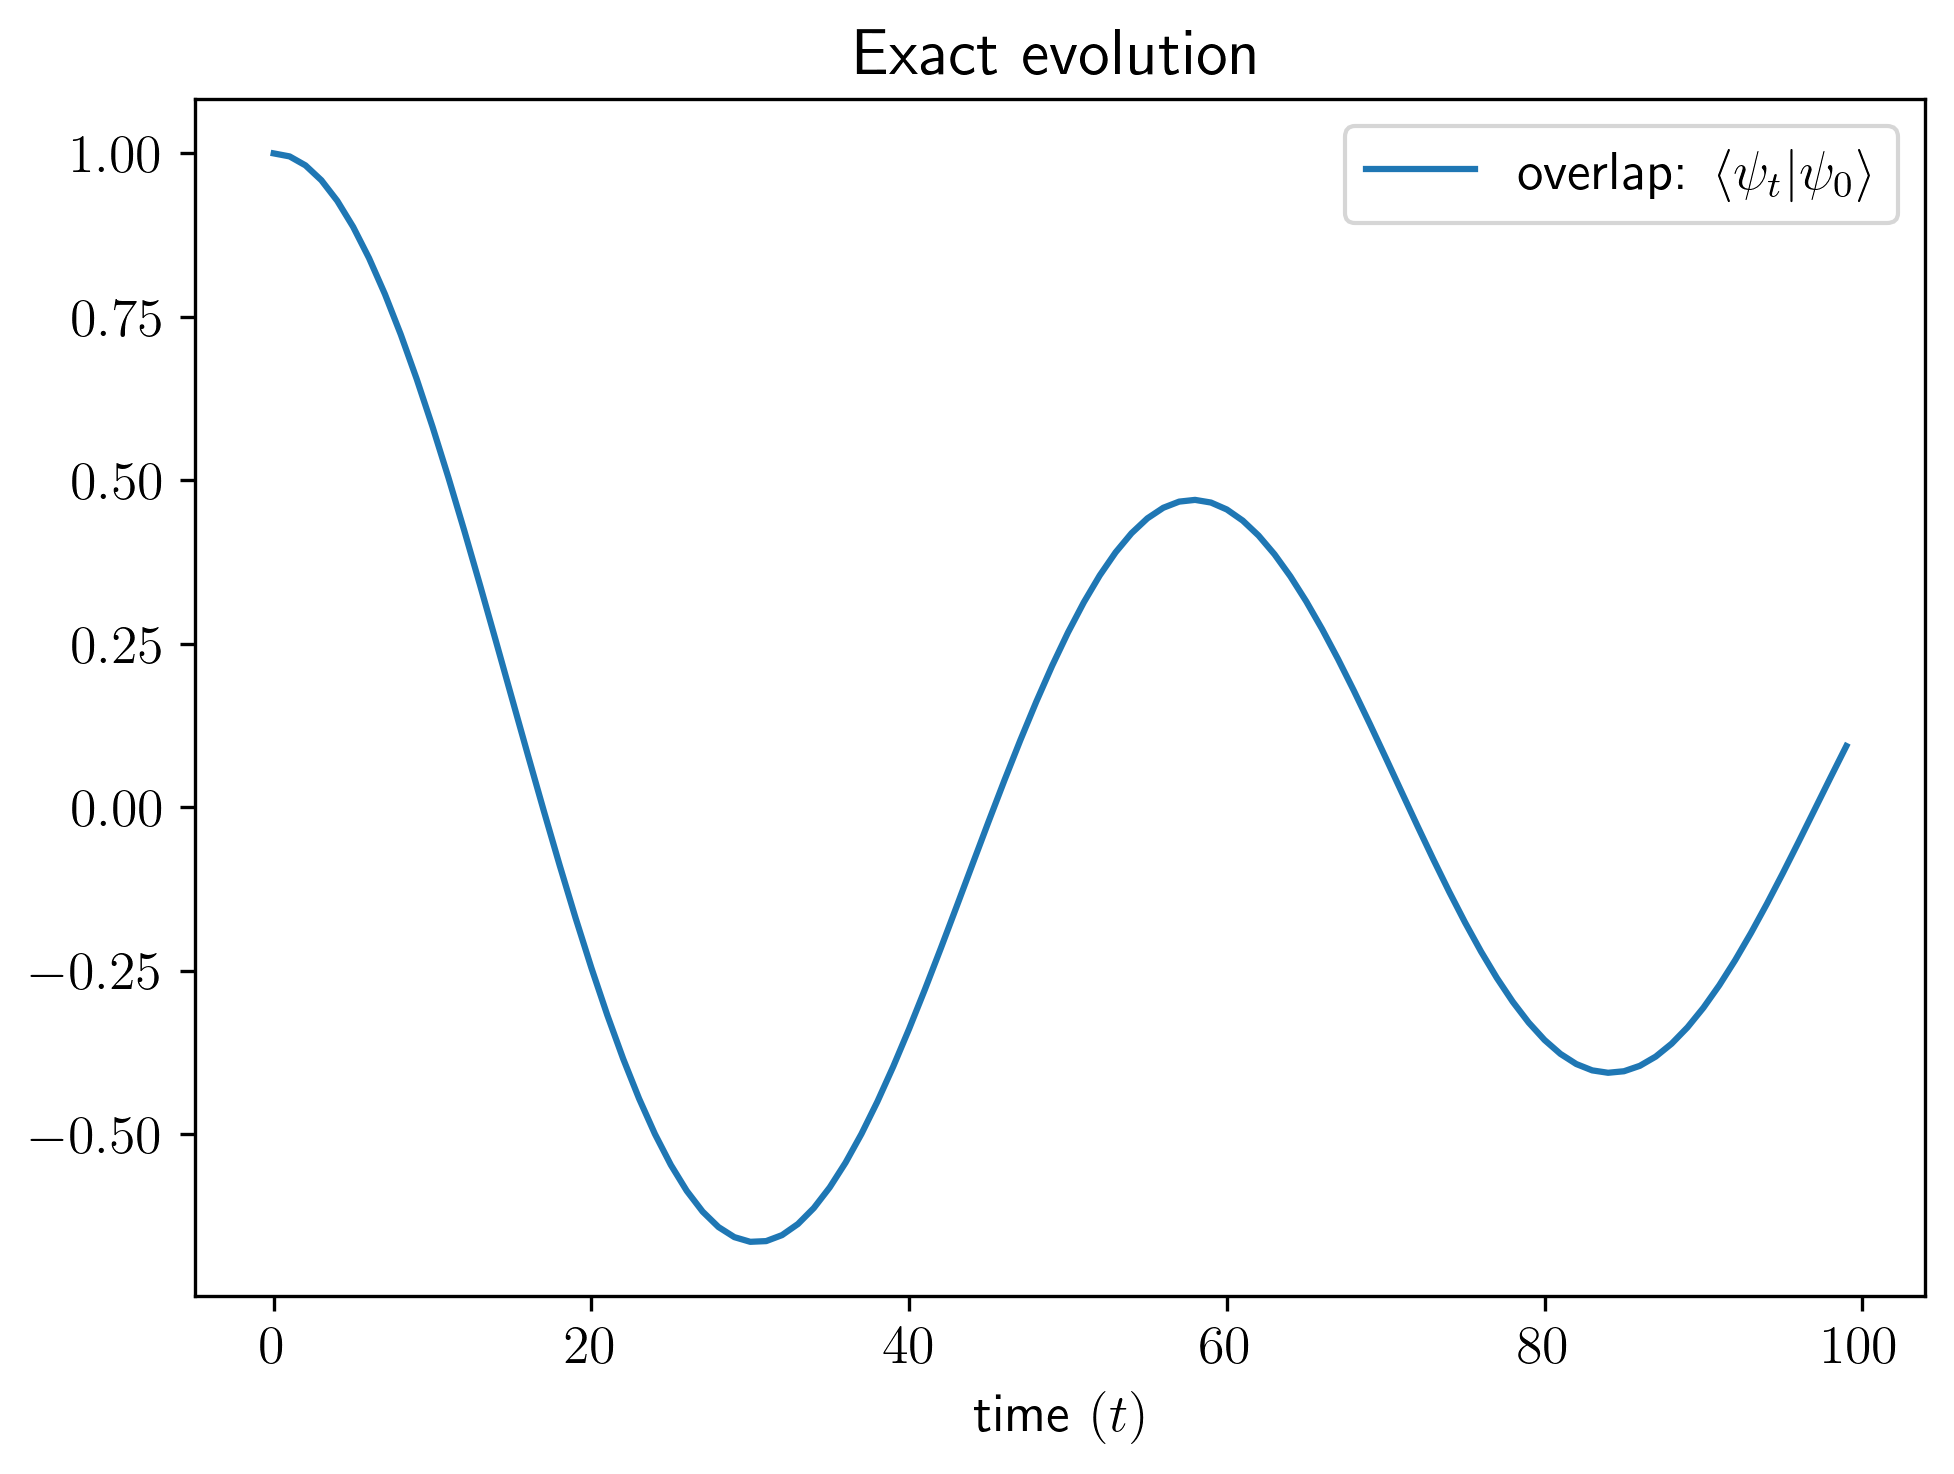

In [63]:
plt.plot(range(steps),fid, label="overlap: $\\langle \\psi_t | \\psi_0 \\rangle$")
plt.title("Exact evolution")
plt.xlabel("time $(t)$")
plt.legend()
plt.show()

In [66]:
l = 2
L = 3
g_r = 0.75
cx = [1,2]
cy = [0,0]
steps = 100
delta = 0.01
from scipy.sparse.linalg import expm

H_sr = dual_ham(l,L,g_r,cx,cy)

# initialize psi and evolution trotter op
psi_ev = psi0
U_sr = expm(-1j*delta*H_sr)

# observable, e.g. fidelity
fid = []
for N in range(steps):
    t = N*delta
    print(f"exact evolution at time: {t}")
    psi_ev = U_sr @ psi_ev
    overlap = (psi_ev.T.conjugate() @ psi0).real
    fid.append(overlap)
    print(f"fidelity: {overlap}")

exact evolution at time: 0.0
fidelity: 0.9954030462367196
exact evolution at time: 0.01
fidelity: 0.9816644320694106
exact evolution at time: 0.02
fidelity: 0.958940266476056
exact evolution at time: 0.03
fidelity: 0.9274886309925299
exact evolution at time: 0.04
fidelity: 0.8876664570216006
exact evolution at time: 0.05
fidelity: 0.8399252086095401
exact evolution at time: 0.06
fidelity: 0.784805424407549
exact evolution at time: 0.07
fidelity: 0.722930186713671
exact evolution at time: 0.08
fidelity: 0.6549975988128266
exact evolution at time: 0.09
fidelity: 0.5817723641301429
exact evolution at time: 0.1
fidelity: 0.5040765718310458
exact evolution at time: 0.11
fidelity: 0.42277980330064124
exact evolution at time: 0.12
fidelity: 0.33878868229171977
exact evolution at time: 0.13
fidelity: 0.2530359983402532
exact evolution at time: 0.14
fidelity: 0.16646953822459565
exact evolution at time: 0.15
fidelity: 0.08004076372498098
exact evolution at time: 0.16
fidelity: -0.00530652431934

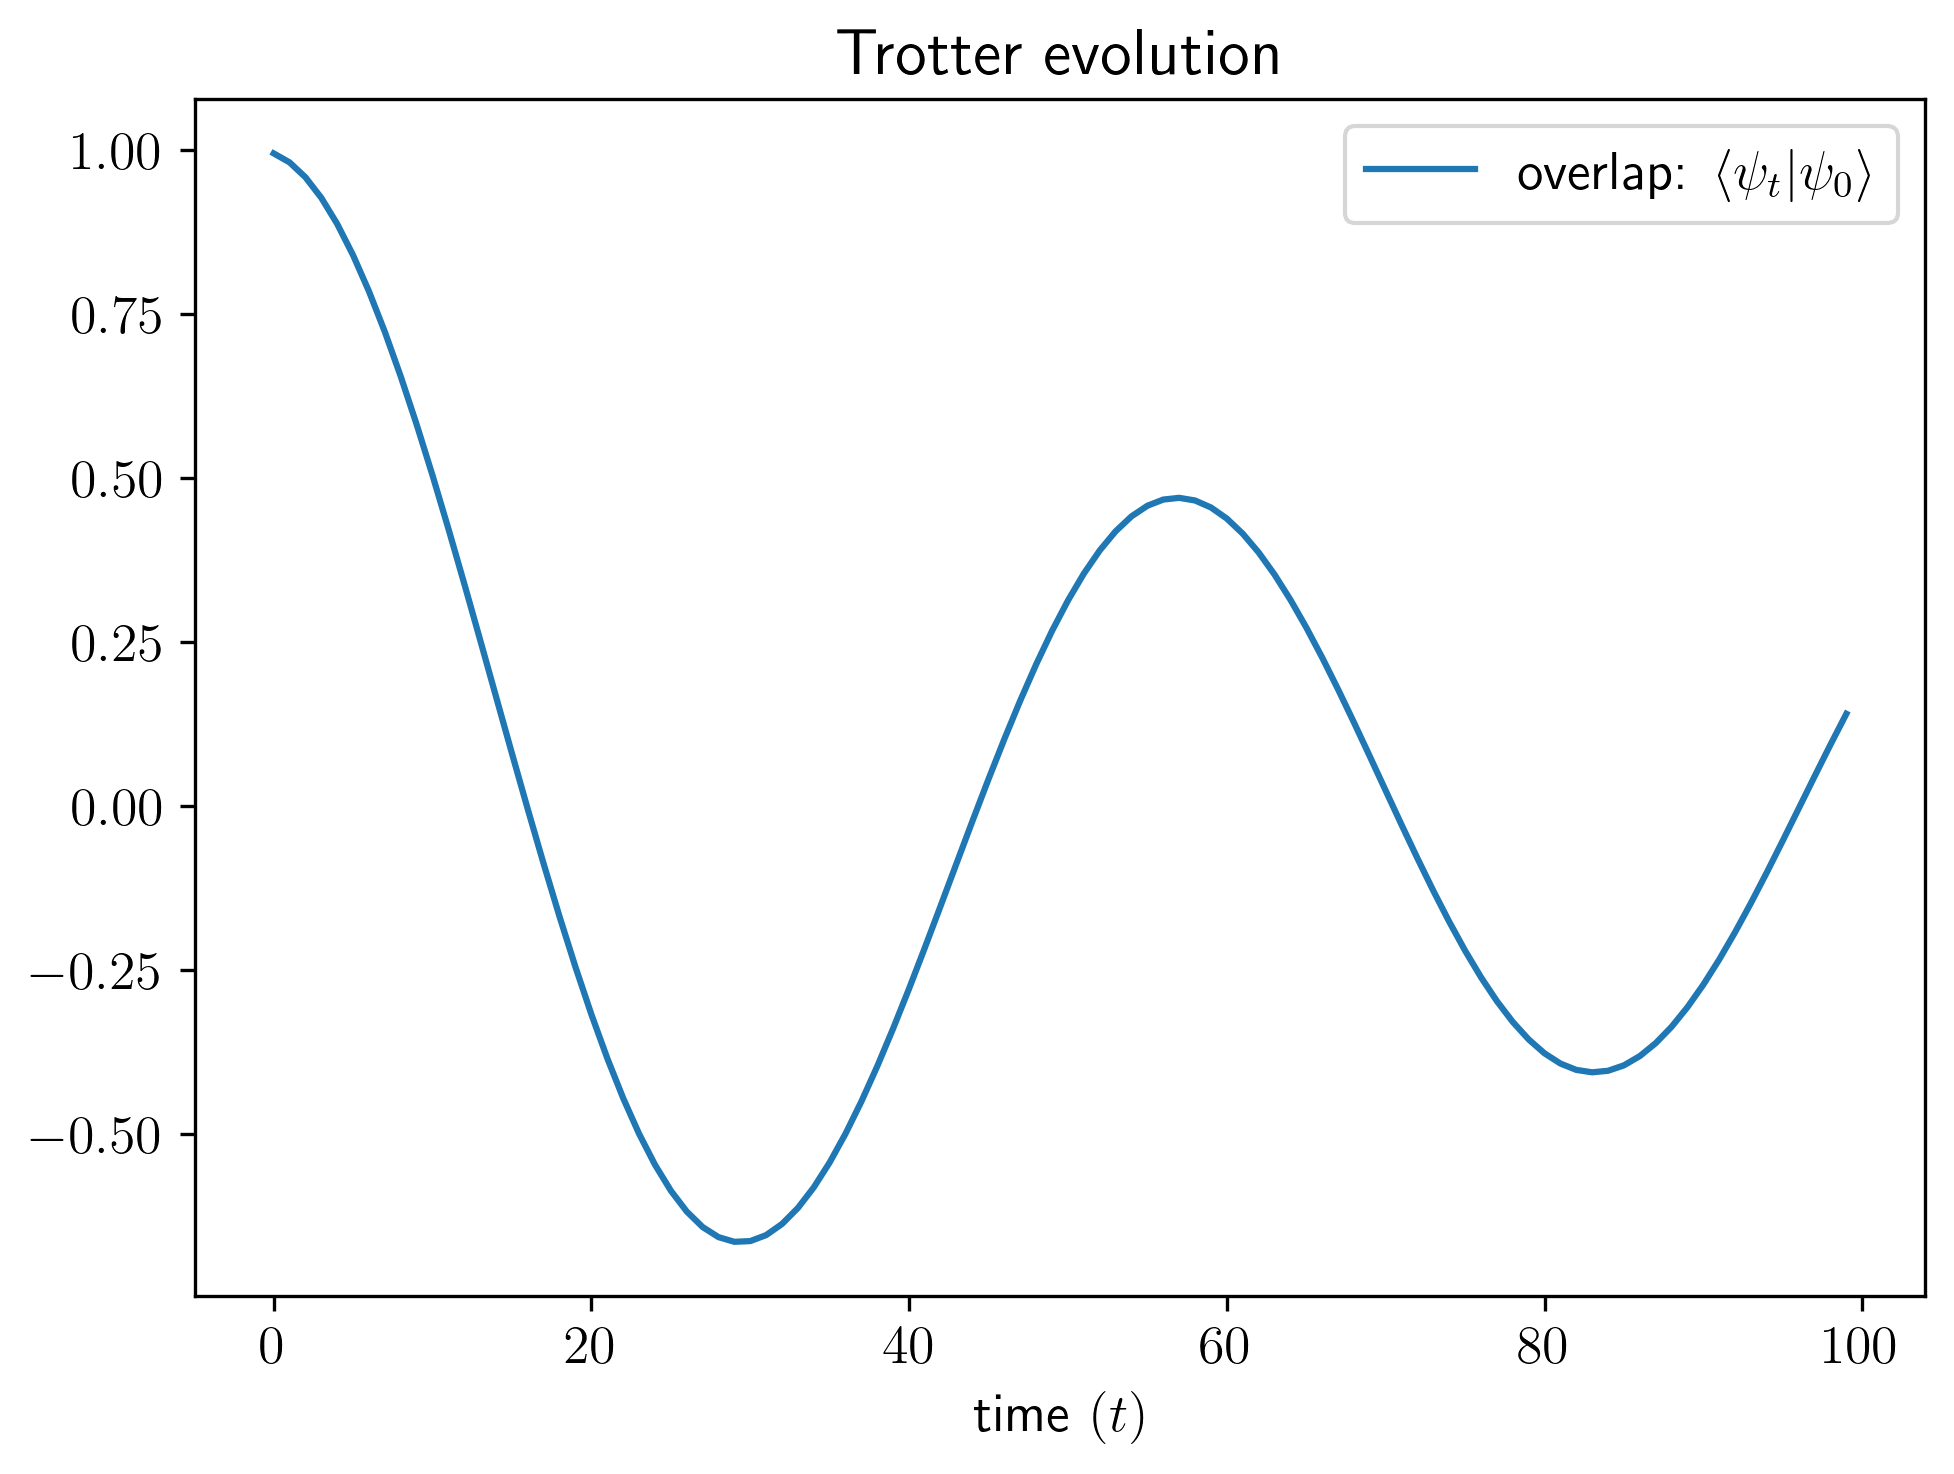

In [67]:
plt.plot(range(steps),fid, label="overlap: $\\langle \\psi_t | \\psi_0 \\rangle$")
plt.title("Trotter evolution")
plt.xlabel("time $(t)$")
plt.legend()
plt.show()

## 2. Build evolution MPO for PBC

## 3. Compare MPO and Exact results